Sources:
- https://machinelearningmastery.com/cost-sensitive-learning-for-imbalanced-classification/
- https://www.kaggle.com/code/janiobachmann/credit-fraud-dealing-with-imbalanced-datasets

In [1]:
from itertools import product
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

from lib.creditcard_fraud_dataset import get_train_test_dfs
from lib.cs_train import train_clf
from lib.cs_eval import evaluate_clf

Text(0.5, 1.0, 'Class Distributions \n (0: No Fraud || 1: Fraud)')

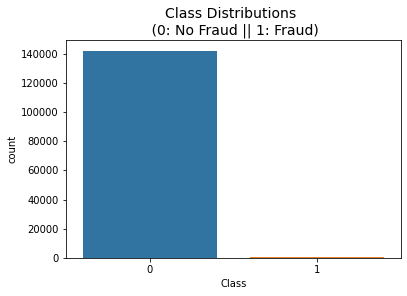

In [2]:
df_trainval, df_test = get_train_test_dfs()

sns.countplot(x='Class', data=df_trainval)
plt.title('Class Distributions \n (0: No Fraud || 1: Fraud)', fontsize=14)

## Cost matrix

Remember the **confusion matrix** of a binary classifier:

|                    | Actual Negative | Actual Positive |
|--------------------|-----------------|-----------------|
| Predicted Negative | TN              | FN              |
| Predicted Positive | FP              | TP              |


In many applications, the cost of false positive predictions is not the same as the cost of false negative predictions. We can try to assign a cost to each cell of the confusion matrix. As such, we obtain the **cost matrix**:

|                    | Actual Negative | Actual Positive |
|--------------------|-----------------|-----------------|
| Predicted Negative | $C_{TN}$        | $C_{FN}$        |
| Predicted Positive | $C_{FP}$        | $C_{TP}$        |

Often, $C_{TN} = C_{TP} = 0$, so this reduces to:

|                    | Actual Negative | Actual Positive |
|--------------------|-----------------|-----------------|
| Predicted Negative | $0$             | $C_{FN}$        |
| Predicted Positive | $C_{FP}$        | $0$             |

We can define the total cost of a classifier using this framework as the **cost-weighted sum of the False Negatives and False Positives**:

$$
\text{Total Cost} = C_{FN} \cdot \text{FN} + C_{FP} \cdot \text{FP}
$$

This is the value that we seek to minimize in cost-sensitive learning.

In [3]:
methods = {}

In [4]:
methods.update({
    'Class Unbalanced, Sample Unweighted': {
        'train': lambda df_train: dict(
            class_weight=None,
            sample_weight=None,
        ),
        'test': lambda df_test: dict()
    },
    'Class Balanced, Sample Unweighted': {
        'train': lambda df_train: dict(
            class_weight='balanced',
            sample_weight=None,
        ),
        'test': lambda df_test: dict()
    },
    'Class Unbalanced, Sample Weighted': {
        'train': lambda df_train: dict(
            class_weight=None,
            sample_weight=df_train['C_misclf'],
        ),
        'test': lambda df_test: dict()
    },
    'Class Balanced, Sample Weighted': {
        'train': lambda df_train: dict(
            class_weight='balanced',
            sample_weight=df_train['C_misclf'],
        ),
        'test': lambda df_test: dict()
    },
})

# Balance dataset by subsampling

In [5]:
methods.update({
    'Subsampled negatives, Sample Weighted': {
        'train': lambda df_train: dict(
            n_neg=df_train['Class'].sum(),
            sample_weight=df_train['C_misclf']
        ),
        'test': lambda df_test: dict()
    },
    'Subsampled negatives, Sample Unweighted': {
        'train': lambda df_train: dict(
            n_neg=df_train['Class'].sum(),
            sample_weight=None
        ),
        'test': lambda df_test: dict()
    }
})

# Using cost-sensitive threshold

Only classify $P_{+}$ as positive if

$$
P_{+} > \frac{C_{FP}}{C_{FP} + C_{FN}}
$$

Test out with balanced and unbalanced classes.

In [6]:
def get_cs_threshs(df):
    return df['C_FP'] / (df['C_FP'] + df['C_FN'])


methods.update({
    "CS thresh, Class Unbalanced": {
        'train': lambda df_train: dict(class_weight='unbalanced'),
        'test': lambda df_test: dict(thresh=get_cs_threshs(df_test)),
    },
    "CS thresh, Class Balanced": {
        'train': lambda df_train: dict(class_weight=None),
        'test': lambda df_test: dict(thresh=get_cs_threshs(df_test)),
    }
})

# Using cost-sensitive sampling

Resample data such that the positive-negative ratio is equal to:

$$
r_{cs} = \frac{|N^+|}{|N^-|}\cdot\frac{C_{FN}}{C_{FP}},
$$

with $|N^+|$ and $|N^-|$ the original number of positive, resp. negative, classes.

In [7]:
def get_cost_sensitive_sampling_ratios(df_train):
    n_pos = df_train['Class'].sum()
    n_neg = len(df_train) - n_pos

    return (df_train['C_FN'] / df_train['C_FP']) * (n_pos / n_neg)


methods.update({
    'Cost-sensitive sampling': {
        'train': lambda df_train: dict(
            n_neg=int(df_train['Class'].sum() / get_cost_sensitive_sampling_ratios(df_train).mean())
        ),
        'test': lambda df_test: dict(),
    }
})

# Evaluation

We compute the percentage of the sum of the amounts of all fraudulent transactions that the model saved by correctly detecting fraud.

In [8]:
from sklearn.model_selection import StratifiedKFold


skf = StratifiedKFold(n_splits=5, random_state=None, shuffle=False)


from lib.creditcard_fraud_dataset import get_X_from_df, get_Y_from_df

df_results = []

for train_index, val_index in tqdm(skf.split(get_X_from_df(df_trainval), get_Y_from_df(df_trainval))):
    df_train = df_trainval.iloc[train_index]
    df_val = df_trainval.iloc[val_index]

    for method_name, method_dict in tqdm(methods.items(), leave=False):
        clf = train_clf(
            df_train,
            **method_dict['train'](df_train)
        )
        eval_metrics = evaluate_clf(
            clf,
            df_val,
            **method_dict['test'](df_val)
        )
        df_results.append({
            'method': method_name,
            **eval_metrics
        })

0it [00:00, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

/home/fdf/miniconda3/envs/sentometrics/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

/home/fdf/miniconda3/envs/sentometrics/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/fdf/miniconda3/envs/sentometrics/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules

  0%|          | 0/9 [00:00<?, ?it/s]

/home/fdf/miniconda3/envs/sentometrics/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [10]:
import pandas as pd

df_results = pd.DataFrame(df_results)

In [20]:
df_results['recall_cs'] = df_results['tp_amount'] / (df_results['tp_amount'] + df_results['fn_amount'])
df_results['precision_cs'] = df_results['tp_amount'] / (df_results['tp_amount'] + df_results['fp_amount'])
df_results['f1_cs'] = 2 * df_results['precision_cs'] * df_results['recall_cs'] / (df_results['precision_cs'] + df_results['recall_cs'])

In [28]:
gb = df_results.groupby('method')

gb.agg('mean').sort_values(by='f1_cs', ascending=False)

,precision,recall,ap,tp_amount,fp_amount,fn_amount,recall_amount,precision_amount,recall_cs,precision_cs,f1_cs
method,,,,,,,,,,,
"Class Unbalanced, Sample Weighted",0.266104,0.845388,0.639488,4602.572,232.4,1171.708,0.792877,0.949840,0.792877,0.949840,0.863752
"CS thresh, Class Balanced",0.288914,0.687429,0.745817,4331.288,166.0,1442.992,0.761995,0.961824,0.761995,0.961824,0.843481
"CS thresh, Class Unbalanced",0.288914,0.687429,0.745817,4331.288,166.0,1442.992,0.761995,0.961824,0.761995,0.961824,0.843481
Cost-sensitive sampling,0.379399,0.845388,0.678133,4177.598,147.2,1596.682,0.739424,0.965602,0.739424,0.965602,0.834276
"Class Balanced, Sample Unweighted",0.065880,0.914367,0.721101,4876.886,1278.8,897.394,0.864755,0.790601,0.864755,0.790601,0.821217
"Subsampled negatives, Sample Unweighted",0.037531,0.898122,0.429783,4734.536,2328.0,1039.744,0.838415,0.672037,0.838415,0.672037,0.739977
"Class Unbalanced, Sample Unweighted",0.871907,0.605959,0.745817,2501.660,9.2,3272.620,0.460141,0.996419,0.460141,0.996419,0.615133
"Class Balanced, Sample Weighted",0.014334,0.934694,0.678705,5466.588,7135.2,307.692,0.948490,0.447500,0.948490,0.447500,0.597422
"Subsampled negatives, Sample Weighted",0.011559,0.934694,0.347872,5502.934,8242.0,271.346,0.958811,0.405895,0.958811,0.405895,0.564314
